In [3]:
from clustering import *
from downloaddata import *
from portfolio_and_performance import *
from trees import *

In [4]:
with open("SP100list.txt") as f:
    nodenames = f.read().splitlines()
data = get_quandl_data(nodenames, startdate='2006-06-27', enddate='2017-06-27')
data.to_csv("SP100_20170627.csv")

In [5]:
window = 100
space = 10

In [6]:
trees = construct_trees(filename="SP100_20170627.csv", window=window,
                        enddate='2017-06-26',
                        startdate='2007-06-26',
                        space=space, tree_type='MST')
sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))
IGtrees = {}
for key in sorteddates:
    IGtrees[key] = NXtoIG(trees[key])

In [10]:
clustersNewman, IGclustersNewman = construct_clusters(IGtrees, method='Newman')
clustersClausetNewman, IGclustersClausetNewman = construct_clusters(IGtrees, method="ClausetNewman")

Newman           14.015873
ClausetNewman    11.003968
dtype: float64


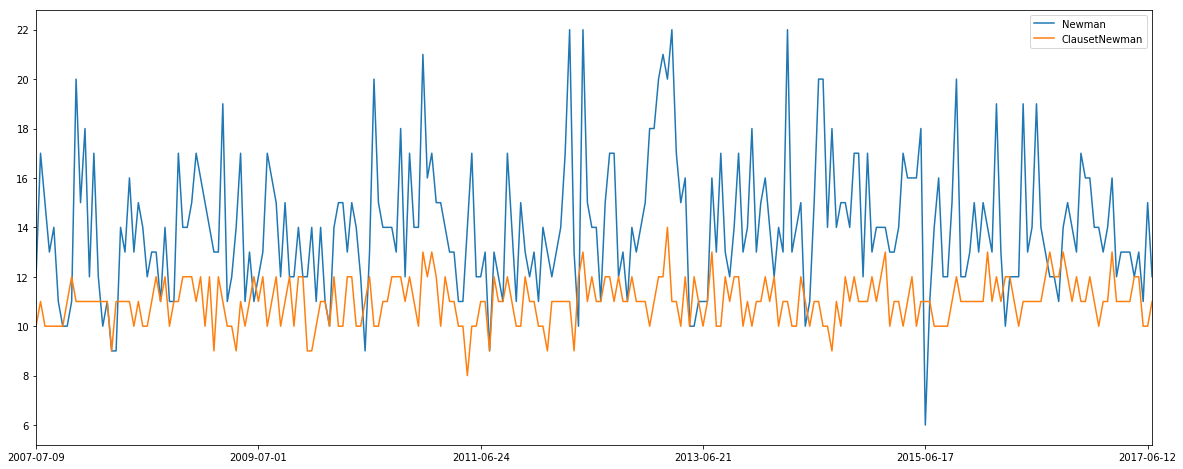

In [12]:
nofclusters = pd.DataFrame(index=sorteddates)
nofclusters['Newman'] = [len(clustersNewman[sorteddates[i]]) for i in range(0, len(sorteddates))]
nofclusters['ClausetNewman'] = [len(clustersClausetNewman[sorteddates[i]]) for i in range(0, len(sorteddates))]
print(np.mean(nofclusters))
%matplotlib inline
nofclusters.plot(figsize=(20, 8))

In [13]:
NewmanUniverse = {}
ClausetNewmanUniverse = {}
for measure in ['degree', 'closeness', 'betweenness']:
    NewmanUniverse[measure] = clustering_universe(trees, clustersNewman, measure, quantile=0)
    ClausetNewmanUniverse[measure] = clustering_universe(trees, clustersClausetNewman, measure, quantile=0)

universes = {}
universes['Newman'] = NewmanUniverse
universes['ClausetNewman'] = ClausetNewmanUniverse

In [14]:
text_file = open("Central-NewmanBetweenness-20170626.txt", "w")
for t in sorteddates:
    text_file.write('%s: ' % t)
    for stock in universes['Newman']['betweenness'][t]['central']:
        text_file.write('%s ' % stock)
    text_file.write('\n')
text_file.close()

In [15]:
performance_weighted, performance_unweighted = benchmark_performance("SP100_20170627.csv",
                                                                     universes, window=window)
performance_comparison_weighted = {'benchmark': performance_weighted}
performance_comparison_unweighted = {'benchmark': performance_unweighted}

In [17]:
for method in ['Newman', 'ClausetNewman']:
    performance_comparison_unweighted[method] = {}
    for measure in ['degree', 'closeness', 'betweenness']:
        temp = clustering_performance(filename="SP100_20170627.csv", universes=universes[method][measure],
                                      weighted='FALSE', window=window)
        performance_comparison_unweighted[method][measure] = pd.DataFrame.from_dict(temp)
        performance_comparison_unweighted[method][measure]['SP100'] = performance_comparison_unweighted['benchmark']['SP100']
for method in ['Newman', 'ClausetNewman']:
    performance_comparison_weighted[method] = {}
    for measure in ['degree', 'closeness', 'betweenness']:
        temp = clustering_performance(filename="SP100_20170627.csv", universes=universes[method][measure],
                                      weighted='TRUE', window=window)
        performance_comparison_weighted[method][measure] = pd.DataFrame.from_dict(temp)
        performance_comparison_weighted[method][measure]['SP100'] = performance_comparison_weighted['benchmark']['SP100']

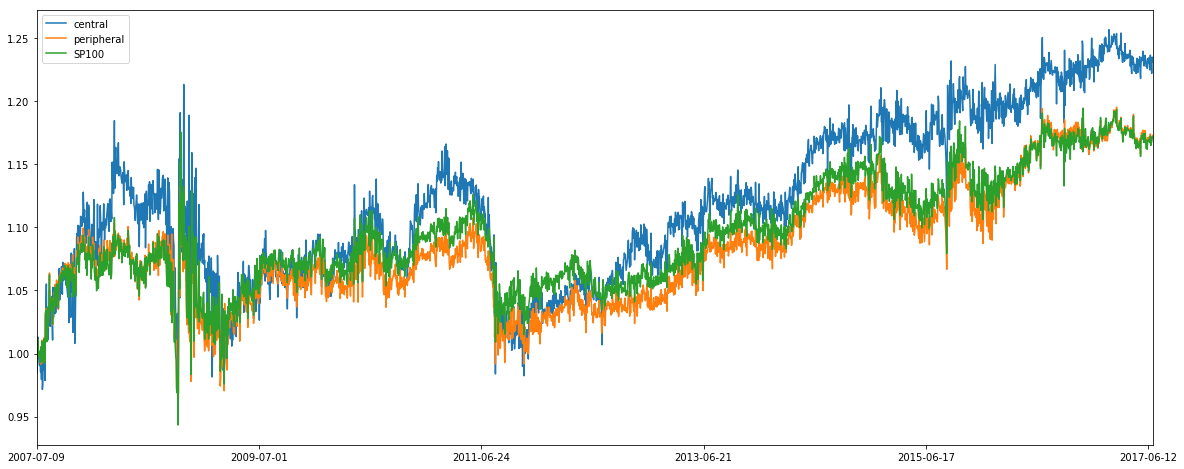

In [17]:
performance_comparison_weighted['Newman']['betweenness'].plot(figsize=(20, 8))